In [1]:
!git clone https://github.com/nageshsinghc4/deepwrap.git
!cd deepwrap/
import os
os.chdir('/content/deepwrap/')
os.getcwd()
!pip install .

Cloning into 'deepwrap'...
remote: Enumerating objects: 279, done.
remote: Counting objects: 100% (279/279), done.
remote: Compressing objects: 100% (239/239), done.
remote: Total 279 (delta 40), reused 256 (delta 27), pack-reused 0
Receiving objects: 100% (279/279), 25.31 MiB | 33.53 MiB/s, done.
Resolving deltas: 100% (40/40), done.
Processing /content/deepwrap
     |████████████████████████████████| 25.9MB 107kB/s 
     |████████████████████████████████| 983kB 48.5MB/s 
     |████████████████████████████████| 245kB 53.8MB/s 
     |████████████████████████████████| 1.1MB 52.2MB/s 
     |████████████████████████████████| 471kB 53.5MB/s 
     |████████████████████████████████| 3.0MB 56.2MB/s 
     |████████████████████████████████| 1.1MB 49.1MB/s 
     |████████████████████████████████| 890kB 48.8MB/s 
  Created wheel for DEEPWRAP: filename=DEEPWRAP-50.3.0-cp36-none-any.whl size=159940 sha256=1c7ae723094d8e5f05910b6a41902d7259d6ca1b91ccff855878b96dc60b783b
  Stored in directory: /tmp/p

In [2]:
#Titanic passenger survival
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import random
import tensorflow as tf
import pandas as pd
pd.set_option('display.max_columns', None)

seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [3]:
import deepwrap
from deepwrap import tabledata

In [4]:
train_df = pd.read_csv('/content/deepwrap/examples/titanic/train.csv', index_col=0)


In [5]:
train_df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [6]:
#We'll drop the Name, Ticket, Cabin columns, as they seem like they'll be less predictive. These columns are largely unique or near-unique to passengers.

train_df = train_df.drop('Name', 1)
train_df = train_df.drop('Ticket', 1)
train_df = train_df.drop('Cabin', 1)

In [7]:
#deepwrap will automatically split out a validation set if given only a training set. But, let's also manually split out a test set that we can evaluate later.
np.random.seed(42)
p = 0.1 # 10% for test set
prop = 1-p
df = train_df.copy()
msk = np.random.rand(len(df)) < prop
train_df = df[msk]
test_df = df[~msk]


In [8]:
test_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
2,1,1,female,38.0,1,0,71.2833,C
12,1,1,female,58.0,0,0,26.5500,S
34,0,2,male,66.0,0,0,10.5000,S
35,0,1,male,28.0,1,0,82.1708,C
44,1,2,female,3.0,1,2,41.5792,C
...,...,...,...,...,...,...,...,...
826,0,3,male,NaN,0,0,6.9500,Q
837,0,3,male,21.0,0,0,8.6625,S
844,0,3,male,34.5,0,0,6.4375,C


In [9]:
train_df.shape


(799, 8)

In [10]:
test_df.shape


(92, 8)

STEP 1: Load and Preprocess the Data


In [11]:
trn, val, preproc = tabledata.load_from_dataframe(train_df, label_columns=['Survived'], random_state=42)


processing train: 717 rows x 8 columns

The following integer column(s) are being treated as categorical variables:
['Pclass', 'SibSp', 'Parch']
To treat any of these column(s) as numerical, cast the column to float in DataFrame or CSV
 and re-run tabular_from* function.

processing test: 82 rows x 8 columns


**Automated Preprocessing**

deepwrap automatically preprocesses the dataset appropriately. Numerical columns are automatically normalized, missing values are handled, and categorical variables will be vectorized as entity embeddings for input to a neural network.

**Auto-generated Features**

deepwrap will auto-generate some new features. For instance, if Age is missing for a particular individual, an Age_na=True feature will be automatically added.

New date features are also automatically added. This dataset does not have any date fields. If it did, we could populate the date_columns parameter to tabular_from_df in which case they would be used to auto-generate new features (e.g., Day, Week, Is_month_start, Is_quarter_end, etc.) using methods adapted from the fastai library.

**Manually-Engineered Features**

In addition to these auto-generated features, one can also optionally add manually-generated, dataset-specific features to train_df prior to invoking tabular_from_df. For instance, the Cabin feature we discarded earlier might be used to extract the deck associated with each passenger (e.g., B22 --> Deck B).

STEP 2: Create a Model and Wrap in Learner


In [12]:
#deepwrap uses multilayer perceptrons as the model for tabular datasets. 
#The model can be configured with arguments to tabular_classifier (e.g., number and size of hidden layers, dropout values, etc.), but we will leave the defaults here.

tabledata.print_tabular_classifiers()

mlp: a configurable multilayer perceptron with categorical variable embeddings [https://arxiv.org/abs/1604.06737]


In [13]:
model = tabledata.tabular_classifier('mlp', trn)


Is Multi-Label? False
done.


In [14]:
learner = deepwrap.get_learner(model, train_data=trn, val_data=val, batch_size=32)


STEP 3: Estimate the Learning Rate


simulating training for different learning rates... this may take a few moments...
Epoch 1/5
22/22 [==============================] - 0s 13ms/step - loss: 0.6851 - accuracy: 0.6292
Epoch 2/5
22/22 [==============================] - 0s 13ms/step - loss: 0.6793 - accuracy: 0.6423
Epoch 3/5
22/22 [==============================] - 0s 13ms/step - loss: 0.6543 - accuracy: 0.6584
Epoch 4/5
22/22 [==============================] - 0s 14ms/step - loss: 1.4948 - accuracy: 0.6964
Epoch 5/5
22/22 [==============================] - 0s 13ms/step - loss: 78.0218 - accuracy: 0.5518


done.
Visually inspect loss plot and select learning rate associated with falling loss


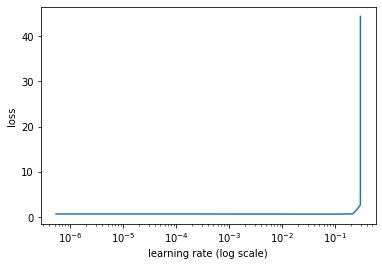

In [15]:
learner.lr_find(show_plot=True, max_epochs=5)


STEP 4: Train the Model


In [16]:
learner.fit_onecycle(5e-3, 10)



begin training using onecycle policy with max lr of 0.005...
Epoch 1/10
23/23 [==============================] - 1s 23ms/step - loss: 0.6449 - accuracy: 0.6527 - val_loss: 0.5673 - val_accuracy: 0.7561
Epoch 2/10
23/23 [==============================] - 0s 16ms/step - loss: 0.5927 - accuracy: 0.6918 - val_loss: 0.5092 - val_accuracy: 0.7927
Epoch 3/10
23/23 [==============================] - 0s 16ms/step - loss: 0.5317 - accuracy: 0.7434 - val_loss: 0.4191 - val_accuracy: 0.8659
Epoch 4/10
23/23 [==============================] - 0s 16ms/step - loss: 0.5038 - accuracy: 0.7824 - val_loss: 0.3803 - val_accuracy: 0.8902
Epoch 5/10
23/23 [==============================] - 0s 16ms/step - loss: 0.4928 - accuracy: 0.7838 - val_loss: 0.3482 - val_accuracy: 0.8659
Epoch 6/10
23/23 [==============================] - 0s 16ms/step - loss: 0.4655 - accuracy: 0.7992 - val_loss: 0.3420 - val_accuracy: 0.9146
Epoch 7/10
23/23 [==============================] - 0s 16ms/step - loss: 0.4402 - accuracy:

In [17]:
#Let's evaluate the validation set
learner.evaluate(val, class_names=preproc.get_classes())

              precision    recall  f1-score   support

not_Survived       0.89      0.96      0.92        49
    Survived       0.93      0.82      0.87        33

    accuracy                           0.90        82
   macro avg       0.91      0.89      0.90        82
weighted avg       0.90      0.90      0.90        82



array([[47,  2],
       [ 6, 27]])

Make Predictions


The Predictor for tabular datasets accepts input as a dataframe in the same format as the original training dataframe.

We will use test_df that we created earlier.

In [19]:
predictor = deepwrap.get_predictor(learner.model, preproc)
preds = predictor.predict(test_df, return_proba=True)
preds.shape


(92, 2)

In [20]:
print('test accuracy:')
(np.argmax(preds, axis=1) == test_df['Survived'].values).sum()/test_df.shape[0]

test accuracy:


0.8369565217391305

In [21]:
df = test_df.copy()[[c for c in test_df.columns.values if c != 'Survived']]
df['Survived'] = test_df['Survived']
df['predicted_Survived'] = np.argmax(preds, axis=1)
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived,predicted_Survived
PassengerId,,,,,,,,,
2,1,female,38.0,1,0,71.2833,C,1,1
12,1,female,58.0,0,0,26.5500,S,1,1
34,2,male,66.0,0,0,10.5000,S,0,0
35,1,male,28.0,1,0,82.1708,C,0,0
44,2,female,3.0,1,2,41.5792,C,1,1


**Explaining Predictions**

We can use the explain method to better understand why a prediction was made for a particular example. Consider the passenger in the fourth row above (PassengerID=35) that did not survive. Although we classified this passenger correctly here, this row tends to get classified differently across different training runs. It is sometimes classified correctly (as in this run), but is also often misclassifeid.

Let's better understand why.

The explain method accepts at minimum the following three inputs:

**df**: a pandas DataFrame in the same format is the original training DataFrame

**row_index**: the DataFrame index of the example (here, we choose PassengerID=35)

**class_id**: the id of the class of interest (we choose the Survived class in this case)

One can also replace the row_index=35 with row_num=3, as both denote the fourth row.

In [22]:
#Explian the predictions 
predictor.explain(test_df, row_index=35, class_id=1)

/content/deepwrap/deepwrap/tabledata/predictor.py:80: UserWarning: TabularPredictor.explain requires shap library. Please install with: pip install shap. Conda users should use this command instead: conda install -c conda-forge shap
  warnings.warn(msg)


 The features in red are causing our model to increase the prediction for the Survived class, while features in blue cause our model to decrease the prediction for Survived (or increase the prediction for Not_Survived).

From the plot, we see that the predicted softmax probability for Survived is 49%, which is a comparatively much less confident classification than other classifications. Why is this?

We see thatSex=male is an influential feature that is pushing the prediction lower towards Not_Survived, as it was women and children given priority when allocating lifeboats on the Titanic.

On the other hand, we also see that this is a First Class passenger (Pclass=1) with a higher-than-average Fare price of 82.17. In the cell below, you'll see that the average Fare price is only 32. (Moreover, this passenger embarked from Cherbourg, which has been shown to be correlated with survival.) Such features suggest that this is an upper-class, wealthier passenger and, therefore, more likely to make it onto a lifeboat and survive. We know from history that crew members were ordered to close gates that lead to the upper decks so the first and second class passengers could be evacuated first. As a result, these "upper class" features are pushing our model to increase the classification to Survived.

Thus, there are two opposing forces at play working against each other in this prediction, which explains why the prediction probability is comparatively nearer to the border than other examples.